# Anime Face Generation Project


In [31]:
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import glob

In [32]:
def show_images(images, nmax=40):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
root = './faces/images/'

In [33]:
image_list = []
rows = []
for filename in glob.glob('./images/*.jpg'):
    im=Image.open(filename)
    rows.append([filename])
    image_list.append(filename)

print(len(image_list))

36740


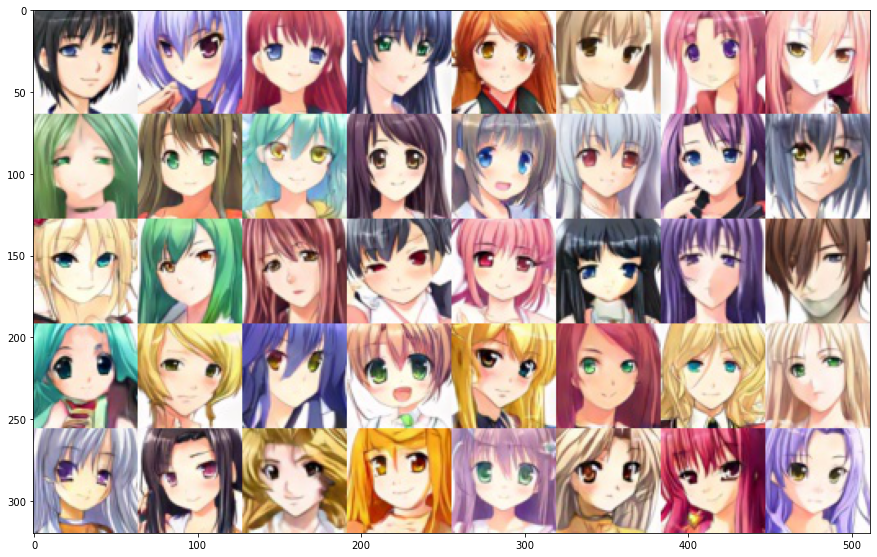

In [34]:
def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

import random
def make_array():
    arr = []
    for i in range(40):
        random_image = random.choice(image_list)
        arr.append(np.asarray(Image.open(random_image).convert('RGB')))
    return np.array(arr)

array = make_array()
result = gallery(array)
plt.figure(figsize=(15,15))
plt.imshow(result)

## Pre-process and Load the Data

In [35]:
df = pd.DataFrame(rows)
df.to_csv('data.csv', index=False, header = None)

In [36]:
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = transforms.Compose([
                                transforms.CenterCrop(64),
                                transforms.Resize(64, interpolation=2),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

class AnimeData(Dataset):
    def __init__(self, root, transform=None):
        self.frame = pd.read_csv(root, header=None)
        self.transform = transform
        
        
    def __len__(self):
        return len(self.frame)
    
    
    def __getitem__(self, index):
        image_name = self.frame.iloc[index, 0]
        image = Image.open(image_name)
        image = self.transform(image)
        return image

trainset = AnimeData(root='./data.csv', transform=transform)
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)

C:\Users\20109\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


# move data to device

In [37]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

#  Discriminator network 

In [38]:
class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.conv_block1(x)
        return x
        
D=Discriminator(3).to(device)

## Generator network


torch.Size([128, 3, 64, 64])


  0%|          | 0/288 [00:00<?, ?it/s]

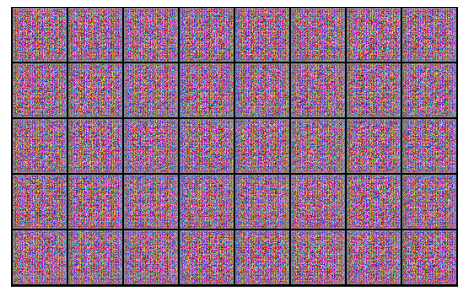

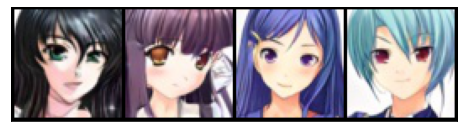

In [41]:
latent_size = 128
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
            
    def forward(self,x):
        x = self.conv_block1(x)
        return x
        
        
G=Generator(latent_size).to(device) 
noise = torch.randn(batch_size, latent_size, 1, 1)

fake_images = G(noise)
print(fake_images.shape)

show_images(fake_images)

for real_images in tqdm(trainloader):
    real_images=(real_images).to(device)
    
show_images(real_images)

## Discriminator and Generator Losses

In [42]:
loss_fn = torch.nn.MSELoss()
def Real_loss(preds,targets):
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds-label_noise)
    return loss

def Fake_loss(preds,targets):
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds+label_noise)
    return loss

## Optimizers

In [43]:
lr=0.0002
opt_d = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

### Save the generated images

In [44]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

## Training GAN to generate anime faces

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 0.7207, loss_d: 0.0766, real_score: 0.9890, fake_score: 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0001.png


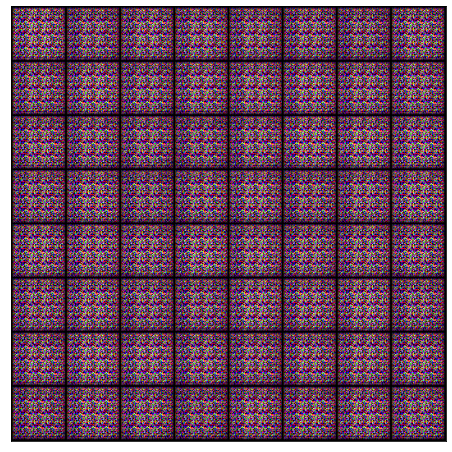

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 0.7292, loss_d: 0.0575, real_score: 0.8351, fake_score: 0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0002.png


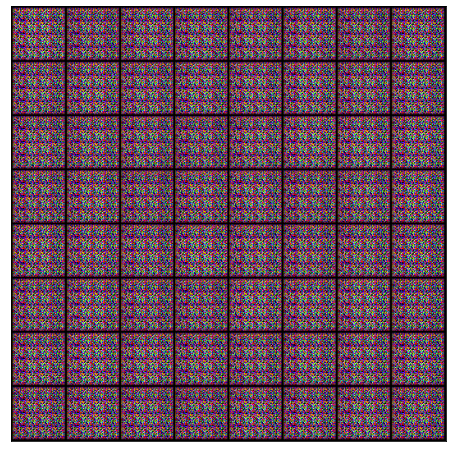

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.5283, loss_d: 0.0732, real_score: 0.6884, fake_score: 0.1938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0003.png


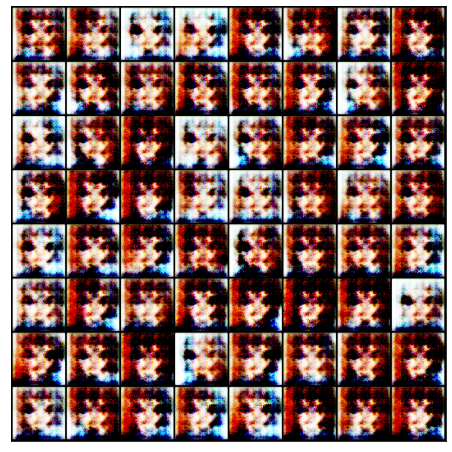

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 0.6927, loss_d: 0.2350, real_score: 0.8702, fake_score: 0.5978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0004.png


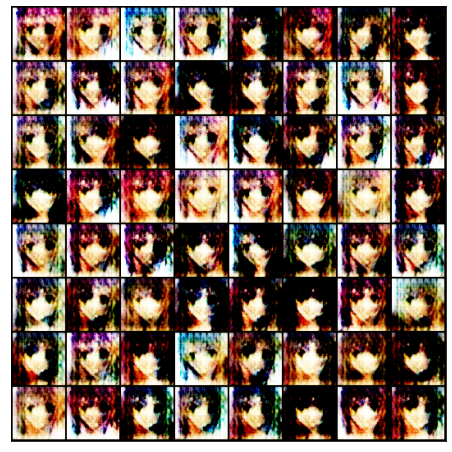

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 0.5030, loss_d: 0.1430, real_score: 0.6113, fake_score: 0.0719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0005.png


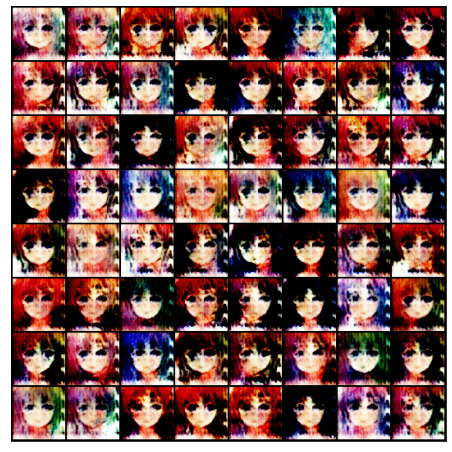

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 0.5320, loss_d: 0.1399, real_score: 0.6785, fake_score: 0.3909


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0006.png


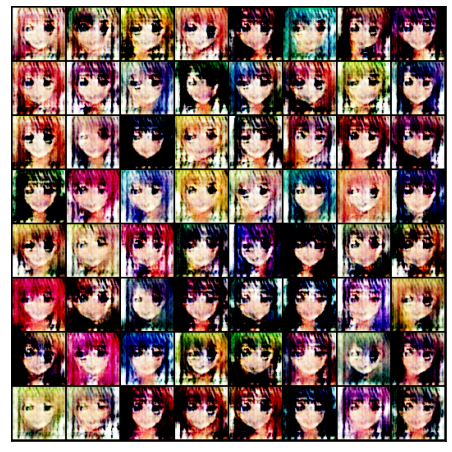

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 0.5865, loss_d: 0.0484, real_score: 0.7053, fake_score: 0.1305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0007.png


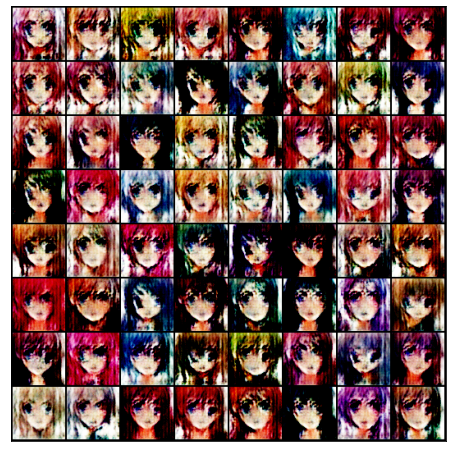

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 0.6291, loss_d: 0.0345, real_score: 0.6768, fake_score: 0.0870


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0008.png


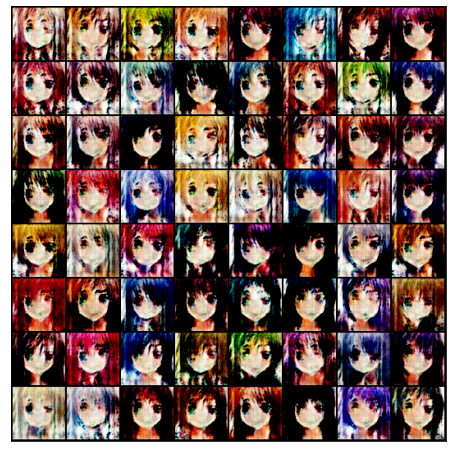

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 0.6551, loss_d: 0.1002, real_score: 0.7134, fake_score: 0.0145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0009.png


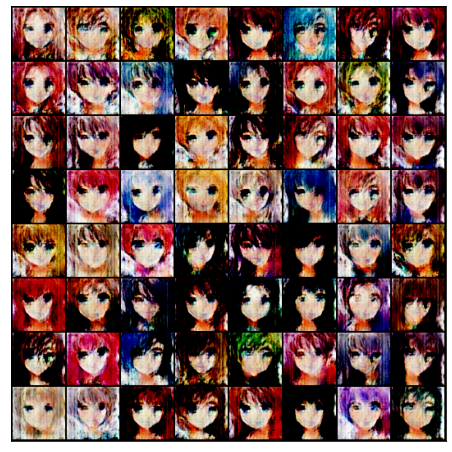

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 0.4621, loss_d: 0.0571, real_score: 0.8156, fake_score: 0.2898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0010.png


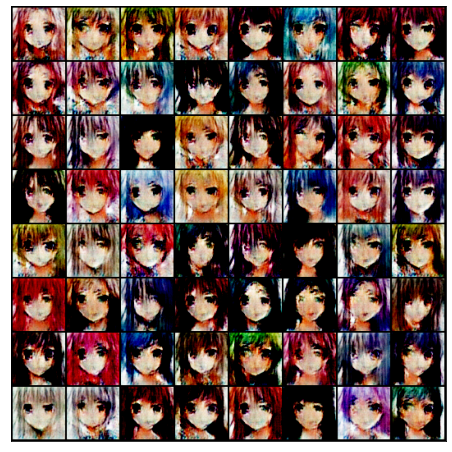

In [45]:
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
def train(D, G, d_optimizer, g_optimizer, epochs=1):
    iter_count = 0
    start_idx=1
    for epoch in range(epochs):
        for real_images in tqdm(trainloader):
            real_images=real_images.to(device)
            D_out_real = D(real_images)  
            label_real = torch.full(D_out_real.shape, 1.0).to(torch.device(device))
            real_loss = Real_loss(label_real,D_out_real)
            real_score = torch.mean(D_out_real).item()
            noise = torch.randn(batch_size, latent_size, 1, 1).to(torch.device(device))
            fake_images =  G(noise)
            D_out_fake = D(fake_images)
            label_fake =  torch.full(D_out_fake.shape, 0).to(torch.device(device))
            fake_loss = Fake_loss(label_fake, D_out_fake) 
            fake_score = torch.mean(D_out_fake).item()
            loss_d = real_loss + fake_loss
            d_optimizer.zero_grad()
            loss_d.backward(retain_graph = True)
            d_optimizer.step()
            noise2 = torch.randn(batch_size, latent_size, 1, 1).to(torch.device(device))
            fake_images2 =  G(noise2)
            gen_steps = 1
            for i in range(0, gen_steps ):
                D_out_fake2 = D(fake_images2)
                label_real1 = torch.full(D_out_fake2.shape, 1.0).to(torch.device(device))
                loss_g = Real_loss(label_real1, D_out_fake2)

                g_optimizer.zero_grad()
                loss_g.backward(retain_graph = (i<gen_steps -1 ))
                g_optimizer.step()
            
            
        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        
        save_samples(epoch+start_idx, fixed_latent,G, show=True)
            
        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint') 
        torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) 
        torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) 
train(D,G,opt_d,opt_g,epochs=10)

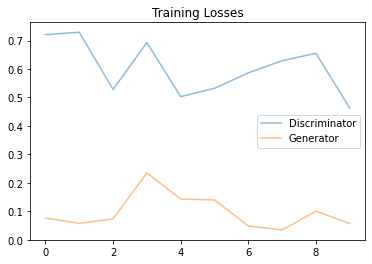

In [46]:
fig, ax = plt.subplots()
plt.plot(losses_g, label='Discriminator', alpha=0.5)
plt.plot(losses_d, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()